<a href="https://colab.research.google.com/github/NahidurRahaman/Pandas/blob/main/Lab04_CNN_task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSE 4622 Lab04: Optimization and Convolutional Neural Networks

Please note that because there is stochasticity in the way we initalize the
neural network weights, so we will get different results (final training/validation
accuracies) if we run the initialization + training multiple times.
You will need to run some of the provided code multiple times to make
a conclusion about what optimization methods work well.

In [1]:
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
import torch.optim as optim

%matplotlib inline

## Data

We'll use the MNIST data set. The MNIST dataset contains black and white, hand-written (numerical) digits that are 28x28 pixels large.
We'll only use the first 2500 images in the MNIST dataset.
The first time you run this code, we will download the MNIST dataset.

In [49]:
from torchvision import datasets, transforms

transform = transforms.ToTensor()

mnist_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
mnist_train = list(mnist_train)[:2500]

mnist_train, mnist_val = mnist_train[:2000], mnist_train[2000:]

## CNN Model in PyTorch



In [48]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=4,
                               kernel_size=3,
                               padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=4,
                               out_channels=8,
                               kernel_size=3,
                               padding=1)
        self.fc = nn.Linear(8 * 8 * 8, 10)
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 8 * 8)
        return self.fc(x)

One way to gauge the "complexity" or the "capacity" of the
neural network is by looking at the number of parameters that it
has.

In [22]:
def print_num_parameters(model, name="model"):
    print("Number of parameters in %s" % name,
          sum(p.numel() for p in model.parameters()))

print_num_parameters(CNN(), "the CNN")

Number of parameters in the CNN 4266


## Training the neural network

We'll use a fairly configurable training function that computes
both training and validation accuracy in each iteration.

In [23]:
def train(model, data, batch_size=64, weight_decay=0.0,
          optimizer="sgd", learning_rate=0.1, momentum=0.9,
          data_shuffle=True, num_epochs=10):
    # training data
    train_loader = torch.utils.data.DataLoader(data,
                                               batch_size=batch_size,
                                               shuffle=data_shuffle)
    # loss function
    criterion = nn.CrossEntropyLoss()
    # optimizer
    assert optimizer in ("sgd", "adam")
    if optimizer == "sgd":
        optimizer = optim.SGD(model.parameters(),
                              lr=learning_rate,
                              momentum=momentum,
                              weight_decay=weight_decay)
    else:
        optimizer = optim.Adam(model.parameters(),
                               lr=learning_rate,
                               weight_decay=weight_decay)
    # track learning curve
    iters, losses, train_acc, val_acc = [], [], [], []
    # training
    n = 0 # the number of iterations (for plotting)
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
            if imgs.size()[0] < batch_size:
                continue

            model.train() # annotate model for training
            out = model(imgs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy(model, train=True)) # compute training accuracy
            val_acc.append(get_accuracy(model, train=False))  # compute validation accuracy
            n += 1

    # plotting
    plt.title("Learning Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Learning Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

And of course, we need the `get_accuracy` helper function. To turn the probabilities
into a discrete prediction, we will take the digit with the highest probability.
Because of the way softmax is computed, the digit with the highest probability is
the same as the digit with the (pre-activation) output value.

In [24]:
def get_accuracy(model, train=False):
    if train:
        data = torch.utils.data.DataLoader(mnist_train, batch_size=4096)
    else:
        data = torch.utils.data.DataLoader(mnist_val, batch_size=1024)

    model.eval() # annotate model for evaluation
    correct = 0
    total = 0
    for imgs, labels in data:
        output = model(imgs) # We don't need to run torch.softmax
        pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

### Train Conv Net


Number of parameters in the CNN 5538


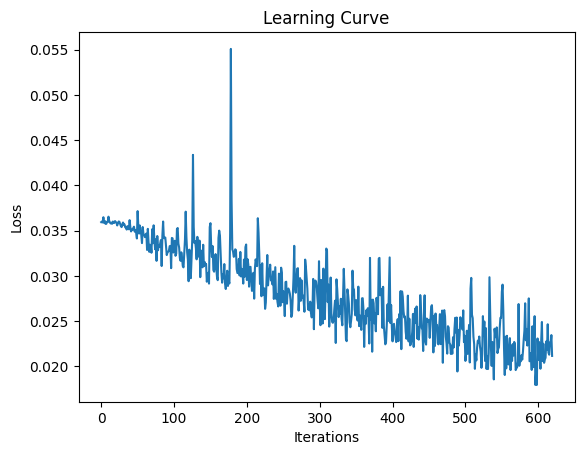

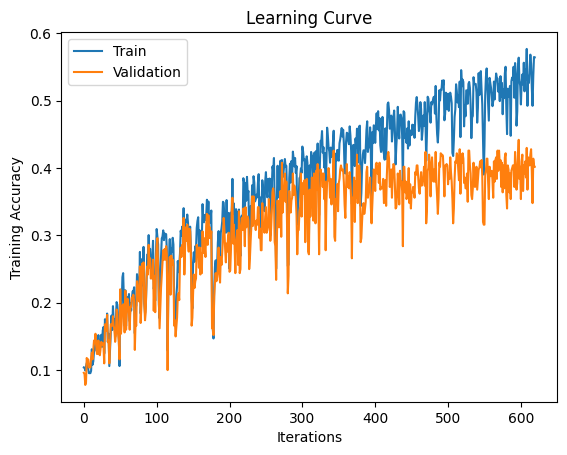

Final Training Accuracy: 0.5645
Final Validation Accuracy: 0.402


In [29]:
model = CNN()
print_num_parameters(model, "the CNN")
train(model, mnist_train, batch_size=64, optimizer="sgd", learning_rate=0.1,
      momentum=0., num_epochs=20)

Convnets can also be trained using SGD with momentum or with Adam.

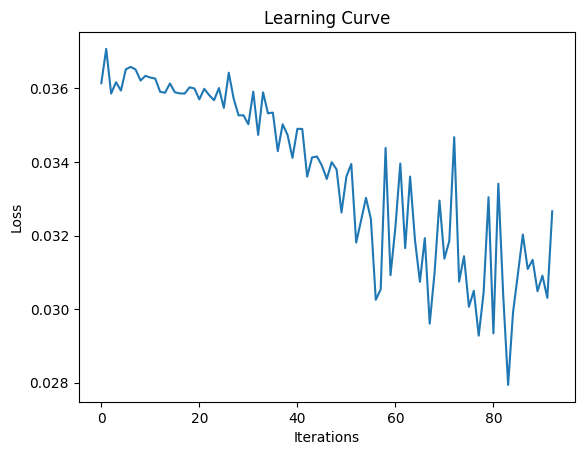

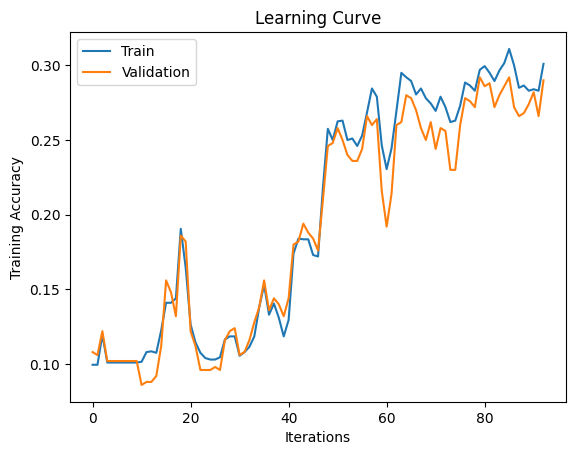

Final Training Accuracy: 0.301
Final Validation Accuracy: 0.29


In [30]:
model = CNN()
train(model, mnist_train, optimizer="adam", learning_rate=0.005, num_epochs=20)

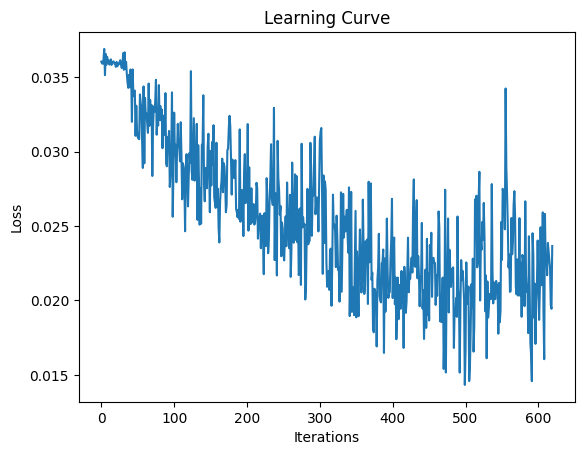

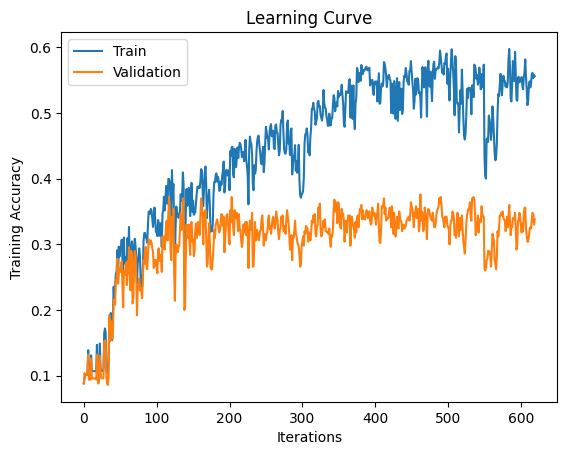

Final Training Accuracy: 0.556
Final Validation Accuracy: 0.338


In [31]:
train(CNN(), mnist_train, learning_rate=0.1, momentum=0.9, num_epochs=20)

## Batch Normalization

Batch normalization speeds up training significantly!

There is a debate as to whether the batch-normalization should be applied
*before* or *after* the activation. The original batch normalization paper
applied the normalization before the ReLU activation, but applying normalization
*after* the ReLU performs better in practice.

I believe the reason to be as follows:

1. If we apply normalization before ReLU, then we are effectively ignoring the
   bias parameter of those units, since those unit's activations gets centered
   anyways.
2. If we apply normalization after ReLU, we will have both positive and negative
   information being passed to the next layer.

Number of parameters in the CNN 5562


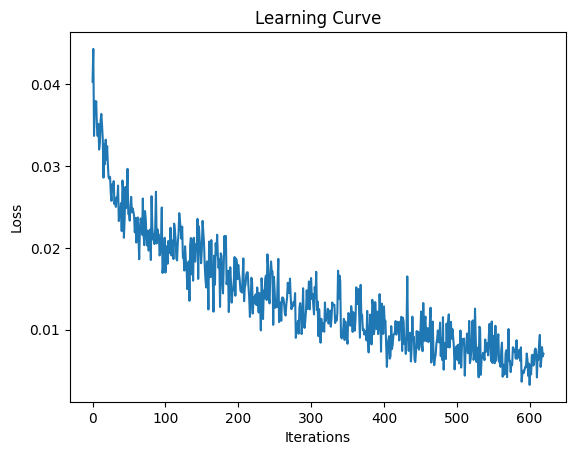

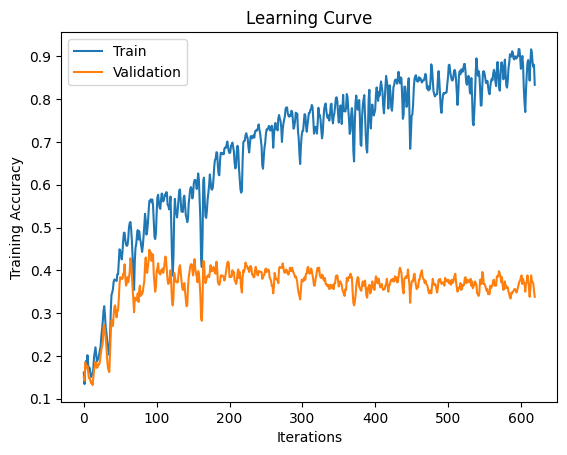

Final Training Accuracy: 0.8335
Final Validation Accuracy: 0.338


In [34]:
class CNNBN(nn.Module):
    def __init__(self):
        super(CNNBN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, # Changed from 1 to 3
                               out_channels=4,
                               kernel_size=3,
                               padding=1)
        self.bn1 = nn.BatchNorm2d(4) # num out channels
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=4,
                               out_channels=8,
                               kernel_size=3,
                               padding=1)
        self.bn2 = nn.BatchNorm2d(8) # num out channels
        self.fc = nn.Linear(8 * 8 * 8, 10) # Changed from 8 * 7 * 7 to 8 * 8 * 8
    def forward(self, x):
        x = self.bn1(torch.relu(self.conv1(x)))
        x = self.pool(x)
        x = self.bn2(torch.relu(self.conv2(x)))
        x = self.pool(x)
        x = x.view(-1, 8 * 8 * 8) # Changed from 8 * 7 * 7 to 8 * 8 * 8
        return self.fc(x)
model = CNNBN()
print_num_parameters(model, "the CNN")
train(model, mnist_train, optimizer="adam", learning_rate=0.005, num_epochs=20)

## Weight Initialization

If we initialize weights to zeros, our neural network will be stuck in a
saddle point. Since we are using stochastic gradient descent, we will see
only noise in the training curve and no progress.

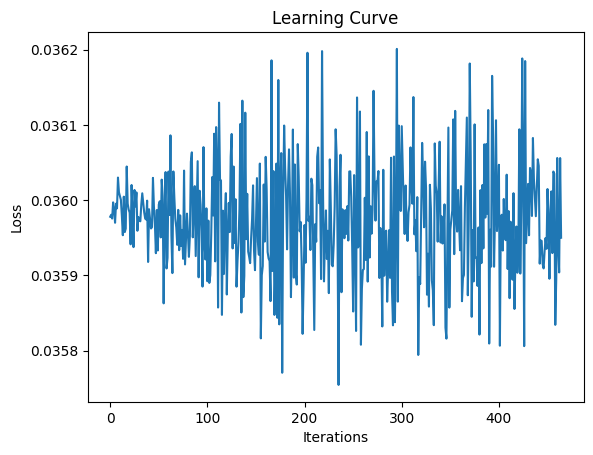

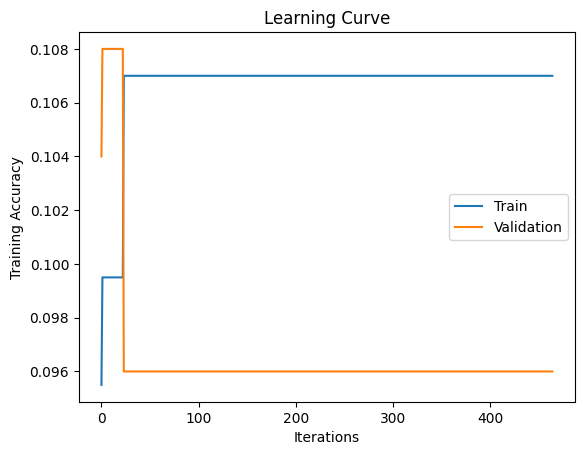

Final Training Accuracy: 0.107
Final Validation Accuracy: 0.096


In [35]:
model = CNN()
for p in model.parameters():
    nn.init.zeros_(p)
train(model, mnist_train, optimizer="adam", learning_rate=0.005, num_epochs=15)

### Assignment 1: Compare CNN with and without Batch Normalization

Tasks:

* Train CNN (without BN) and CNNBN (with BN) on CIFAR-10 for 20 epochs.

* Plot training and validation loss curves.

* Compare accuracy and loss after training.

* Write a short report (~300 words) explaining the difference in convergence speed and generalization.



### Assignment 2: Analyze the Impact of Weight Initialization

Tasks:

Train the CNN with:

* Default PyTorch initialization

* Zero initialization

* Xavier initialization (nn.init.xavier_uniform_)

* Run each for 15 epochs and compare accuracy.

* Plot and analyze the training/validation loss.

* Explain why poor initialization can hurt training performance.